[*********************100%%**********************]  4 of 4 completed


53


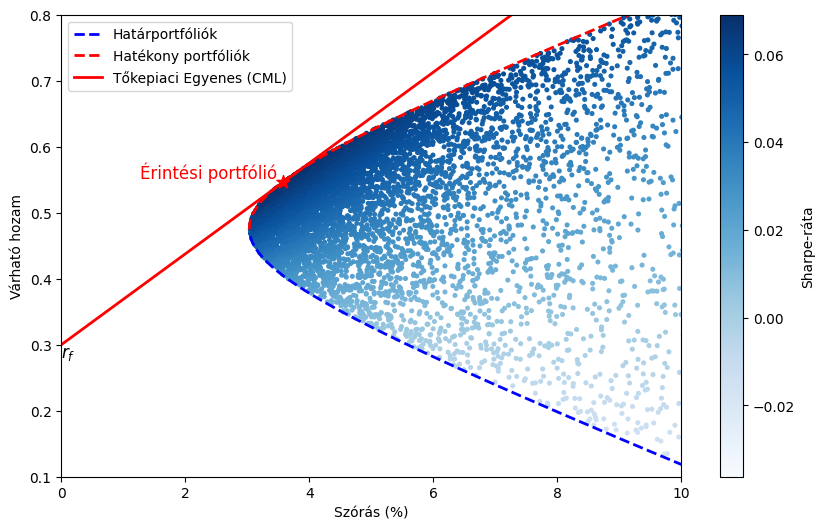

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Function to download stock data
def load_yfinance_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Function to calculate daily returns
def calculate_returns(data):
    return data.pct_change().dropna()

# Function to calculate portfolio statistics
def portfolio_statistics(weights, returns, covariance):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(252)  # Annualized volatility
    return portfolio_return, portfolio_volatility

# Function to calculate the efficient frontier
def efficient_frontier(returns, num_portfolios, risk_free_rate):
    cov_matrix = returns.cov() * 252  # Annualize the covariance matrix
    expected_returns = returns.mean() * 252  # Annualize the returns
    num_assets = len(expected_returns)
    results = np.zeros((4, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.randn(num_assets)
        weights /= np.sum(weights)        
        portfolio_return, portfolio_volatility = portfolio_statistics(weights, returns, cov_matrix)
        results[0,i] = portfolio_volatility
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility  # Sharpe ratio

    return results

# Function to find the minimum variance portfolio
def minimum_variance_portfolio(cov_matrix):
    num_assets = len(cov_matrix)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, cov: np.dot(weights.T, np.dot(cov, weights)),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Function to find the market portfolio (highest Sharpe ratio)
def market_portfolio(returns, covariance, risk_free_rate):
    num_assets = len(returns)
    args = (returns, covariance, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, returns, cov, rf: -(np.dot(weights, returns) - rf) / np.sqrt(np.dot(weights.T, np.dot(cov, weights))),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Plotting function for the efficient frontier
def plot_efficient_frontier(results, exact_frontier_returns, exact_frontier_volatilities, 
                            mvp_return, mvp_volatility, market_return, market_volatility, 
                            risk_free_rate, min_x, max_x, min_y, max_y):
    plt.figure(figsize=(10, 6))

    # Set the same limits as in Manim
    plt.xlim(min_x, max_x )  # Volatility range
    plt.ylim(min_y, max_y )  # Expected return range

    # Scatter plot for simulated portfolios
    results[0,:]+=0.015
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='Blues', marker='o', s=7, alpha=1)
    plt.colorbar(label='Sharpe-ráta')

    # Line plot for the exact efficient frontier
    min_vol =  np.array(exact_frontier_volatilities).min()
    min_vol_pos = np.where(np.array(exact_frontier_volatilities) == min_vol)[0][0]
    print(min_vol_pos)
    plt.plot(exact_frontier_volatilities[:min_vol_pos], exact_frontier_returns[:min_vol_pos], 'b--', label='Határportfóliók', linewidth=2)
    
    plt.plot(exact_frontier_volatilities[min_vol_pos:], exact_frontier_returns[min_vol_pos:], 'r--', label='Hatékony portfóliók', linewidth=2)

   

    

    # # Plot the Capital Market Line (CML)
    cml_x = np.linspace(min_x, max_x, 100)
    cml_y = risk_free_rate + (market_return - risk_free_rate) / market_volatility * cml_x
    plt.plot(cml_x, cml_y, color='red', linestyle='-', label='Tőkepiaci Egyenes (CML)', zorder=1, linewidth=2)
    # plt.text(0.55, 0.3, 'MVP', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='black')

    # plt.scatter(mvp_volatility, mvp_return, color='green', marker='o', s=100, zorder=2)
    # plt.text(mvp_volatility, mvp_return, 'Minimum Variancia Portfólió', fontgnbsize=12, verticalalignment='top', horizontalalignment='left', color='black')

    # Plot the market portfolio with a red color
    plt.scatter(market_volatility, market_return, color='red', marker='*', s=100, zorder=3)
    plt.text(market_volatility-0.1, market_return, 'Érintési portfólió', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='red')
    # sample1_volatility, sample1_return=5,0.5
    # cal_x = np.linspace(min_x, max_x, 100)
    # cal_y = risk_free_rate + (sample1_return - risk_free_rate) / sample1_volatility * cal_x
    # plt.plot(cal_x, cal_y, color='blue', linestyle='-', label='Tőkeallokációs egyenesek (CAL)', zorder=1)
    # # plt.text(0.55, 0.3, 'MVP', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='black')

    # # Plot the market portfolio with a red color
    # plt.scatter(sample1_volatility, sample1_return, color='red', marker='o', s=100, zorder=3)
    # plt.text(sample1_volatility, sample1_return, '$P_1$', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')
    
    # sample2_volatility, sample2_return= 8, 0.4
    # cal_x = np.linspace(min_x, max_x, 100)
    # cal_y = risk_free_rate + (sample2_return - risk_free_rate) / sample2_volatility * cal_x
    # plt.plot(cal_x, cal_y, color='blue', linestyle='-', zorder=1)
    # # plt.text(0.55, 0.3, 'MVP', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='black')

    # # Plot the market portfolio with a red color
    # plt.scatter(sample2_volatility, sample2_return, color='red', marker='o', s=100, zorder=3)
    # plt.text(sample2_volatility, sample2_return, '$P_2$', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')

    # plt.scatter(0, risk_free_rate, color='blue', marker='x', s=100, zorder=3)
    plt.text(0, risk_free_rate, '$r_f$', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')
    
    
    # plt.title('Hatékony határvonal és tőkepiaci vonal')
    plt.xlabel('Szórás (%)')
    plt.ylabel('Várható hozam')
    plt.legend()
    # plt.show()

# Loading data
risk_free_rate=0.3
num_portfolios=10000
min_x, max_x = 0, 10
min_y, max_y = 0.1, 0.8
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
data = load_yfinance_data(tickers, '2023-01-01', '2024-01-01')
returns = calculate_returns(data)

# Simulated efficient frontier
results = efficient_frontier(returns, num_portfolios, risk_free_rate)

# Exact efficient frontier calculations (refactored from the previous code)

mu = returns.mean() * 252  # Annualize the daily returns
Sigma = returns.cov() * 252  # Annualize the daily covariances
Sigma_inv = np.linalg.inv(Sigma)
ones = np.ones(len(mu))
U = np.vstack([mu, ones]).T
M = U.T@ (Sigma_inv@ U)
M_inv = np.linalg.inv(M)
desired_returns = np.linspace(min_y, max_y , 100)  # Adjusted to match Manim
exact_weights_list = []
exact_risk_list = []

for desired_return in desired_returns:
    u = np.array([desired_return, 1])
    w_star = Sigma_inv@ U@ M_inv@u
    portfolio_risk = np.sqrt(np.dot(w_star.T, np.dot(Sigma, w_star))) * np.sqrt(252)
    exact_weights_list.append(w_star)
    exact_risk_list.append(portfolio_risk)

# Find the minimum variance portfolio
mvp_weights = minimum_variance_portfolio(Sigma)
mvp_return, mvp_volatility = portfolio_statistics(mvp_weights, returns, Sigma)

# Find the market portfolio
market_weights = market_portfolio(mu, Sigma, risk_free_rate)
market_return, market_volatility = portfolio_statistics(market_weights, returns, Sigma)

# Plot both the simulated and exact efficient frontiers
plot_efficient_frontier(results, desired_returns, exact_risk_list, mvp_return, mvp_volatility, market_return, market_volatility, risk_free_rate, min_x, max_x, min_y, max_y)
plt.savefig("../../../static/MPT/MPT2.svg", format='svg', transparent=True, bbox_inches='tight')

# Show the plot
plt.show()


[*********************100%%**********************]  4 of 4 completed


53


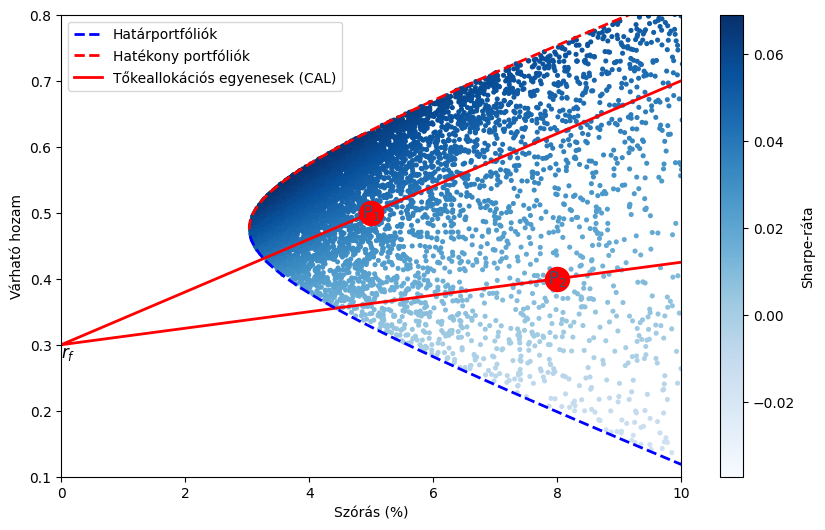

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Function to download stock data
def load_yfinance_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Function to calculate daily returns
def calculate_returns(data):
    return data.pct_change().dropna()

# Function to calculate portfolio statistics
def portfolio_statistics(weights, returns, covariance):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(252)  # Annualized volatility
    return portfolio_return, portfolio_volatility

# Function to calculate the efficient frontier
def efficient_frontier(returns, num_portfolios, risk_free_rate):
    cov_matrix = returns.cov() * 252  # Annualize the covariance matrix
    expected_returns = returns.mean() * 252  # Annualize the returns
    num_assets = len(expected_returns)
    results = np.zeros((4, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.randn(num_assets)
        weights /= np.sum(weights)        
        portfolio_return, portfolio_volatility = portfolio_statistics(weights, returns, cov_matrix)
        results[0,i] = portfolio_volatility
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility  # Sharpe ratio

    return results

# Function to find the minimum variance portfolio
def minimum_variance_portfolio(cov_matrix):
    num_assets = len(cov_matrix)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, cov: np.dot(weights.T, np.dot(cov, weights)),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Function to find the market portfolio (highest Sharpe ratio)
def market_portfolio(returns, covariance, risk_free_rate):
    num_assets = len(returns)
    args = (returns, covariance, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, returns, cov, rf: -(np.dot(weights, returns) - rf) / np.sqrt(np.dot(weights.T, np.dot(cov, weights))),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Plotting function for the efficient frontier
def plot_efficient_frontier(results, exact_frontier_returns, exact_frontier_volatilities, 
                            mvp_return, mvp_volatility, market_return, market_volatility, 
                            risk_free_rate, min_x, max_x, min_y, max_y):
    plt.figure(figsize=(10, 6))

    # Set the same limits as in Manim
    plt.xlim(min_x, max_x )  # Volatility range
    plt.ylim(min_y, max_y )  # Expected return range

    # Scatter plot for simulated portfolios
    results[0,:]+=0.015
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='Blues', marker='o', s=7, alpha=1)
    plt.colorbar(label='Sharpe-ráta')

    # Line plot for the exact efficient frontier
    min_vol =  np.array(exact_frontier_volatilities).min()
    min_vol_pos = np.where(np.array(exact_frontier_volatilities) == min_vol)[0][0]
    print(min_vol_pos)
    plt.plot(exact_frontier_volatilities[:min_vol_pos], exact_frontier_returns[:min_vol_pos], 'b--', label='Határportfóliók', linewidth=2)
    
    plt.plot(exact_frontier_volatilities[min_vol_pos:], exact_frontier_returns[min_vol_pos:], 'r--', label='Hatékony portfóliók', linewidth=2)

   

   

    # # Plot the Capital Market Line (CML)
    # cml_x = np.linspace(min_x, max_x, 100)
    # cml_y = risk_free_rate + (market_return - risk_free_rate) / market_volatility * cml_x
    # plt.plot(cml_x, cml_y, color='red', linestyle='-', label='Tőkepiaci Egyenes (CML)', zorder=1)
    # # plt.text(0.55, 0.3, 'MVP', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='black')

    # plt.scatter(mvp_volatility, mvp_return, color='green', marker='o', s=100, zorder=2)
    # plt.text(mvp_volatility, mvp_return, 'Minimum Variancia Portfólió', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')

    # Plot the market portfolio with a red color
    # plt.scatter(market_volatility, market_return, color='red', marker='o', s=100, zorder=3)
    # plt.text(market_volatility, market_return, 'Piaci Portfólió', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')
    sample1_volatility, sample1_return=5,0.5
    cal_x = np.linspace(min_x, max_x, 100)
    cal_y = risk_free_rate + (sample1_return - risk_free_rate) / sample1_volatility * cal_x
    plt.plot(cal_x, cal_y, color='red', linestyle='-', label='Tőkeallokációs egyenesek (CAL)', zorder=1, linewidth=2)
    # plt.text(0.55, 0.3, 'MVP', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='black')

    # Plot the market portfolio with a red color
    plt.scatter(sample1_volatility, sample1_return, color='red', marker='o', s=300, zorder=3)
    plt.text(sample1_volatility, sample1_return, '$\\text{P}_1$',  verticalalignment='center', horizontalalignment='center', fontsize=12,color='#335574')
    
    sample2_volatility, sample2_return= 8, 0.4
    cal_x = np.linspace(min_x, max_x, 100)
    cal_y = risk_free_rate + (sample2_return - risk_free_rate) / sample2_volatility * cal_x
    plt.plot(cal_x, cal_y, color='red', linestyle='-', zorder=1, linewidth=2)
    # plt.text(0.55, 0.3, 'MVP', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='black')

    # Plot the market portfolio with a red color
    plt.scatter(sample2_volatility, sample2_return, color='red', marker='o', s=300, zorder=3)
    plt.text(sample2_volatility, sample2_return, '$\\text{P}_2$', fontsize=12, verticalalignment='center', horizontalalignment='center', color='#335574')

    # plt.scatter(0, risk_free_rate, color='blue', marker='x', s=100, zorder=3)
    # plt.scatter(0, risk_free_rate, color='red', marker='*', s=100, zorder=3)
    plt.text(0, risk_free_rate, '$r_f$', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')
    
    
    # plt.title('Hatékony határvonal és tőkepiaci vonal')
    plt.xlabel('Szórás (%)')
    plt.ylabel('Várható hozam')
    plt.legend()
    # plt.show()

# Loading data
risk_free_rate=0.3
num_portfolios=10000
min_x, max_x = 0, 10
min_y, max_y = 0.1, 0.8
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
data = load_yfinance_data(tickers, '2023-01-01', '2024-01-01')
returns = calculate_returns(data)

# Simulated efficient frontier
results = efficient_frontier(returns, num_portfolios, risk_free_rate)

# Exact efficient frontier calculations (refactored from the previous code)

mu = returns.mean() * 252  # Annualize the daily returns
Sigma = returns.cov() * 252  # Annualize the daily covariances
Sigma_inv = np.linalg.inv(Sigma)
ones = np.ones(len(mu))
U = np.vstack([mu, ones]).T
M = U.T@ (Sigma_inv@ U)
M_inv = np.linalg.inv(M)
desired_returns = np.linspace(min_y, max_y , 100)  # Adjusted to match Manim
exact_weights_list = []
exact_risk_list = []

for desired_return in desired_returns:
    u = np.array([desired_return, 1])
    w_star = Sigma_inv@ U@ M_inv@u
    portfolio_risk = np.sqrt(np.dot(w_star.T, np.dot(Sigma, w_star))) * np.sqrt(252)
    exact_weights_list.append(w_star)
    exact_risk_list.append(portfolio_risk)

# Find the minimum variance portfolio
mvp_weights = minimum_variance_portfolio(Sigma)
mvp_return, mvp_volatility = portfolio_statistics(mvp_weights, returns, Sigma)

# Find the market portfolio
market_weights = market_portfolio(mu, Sigma, risk_free_rate)
market_return, market_volatility = portfolio_statistics(market_weights, returns, Sigma)

# Plot both the simulated and exact efficient frontiers
plot_efficient_frontier(results, desired_returns, exact_risk_list, mvp_return, mvp_volatility, market_return, market_volatility, risk_free_rate, min_x, max_x, min_y, max_y)
# Save the chart as an SVG file with custom colors and transparent background
plt.savefig("../../../static/MPT/MPT1.svg", format='svg', transparent=True, bbox_inches='tight')

# Show the plot
plt.show()


[*********************100%%**********************]  4 of 4 completed


53


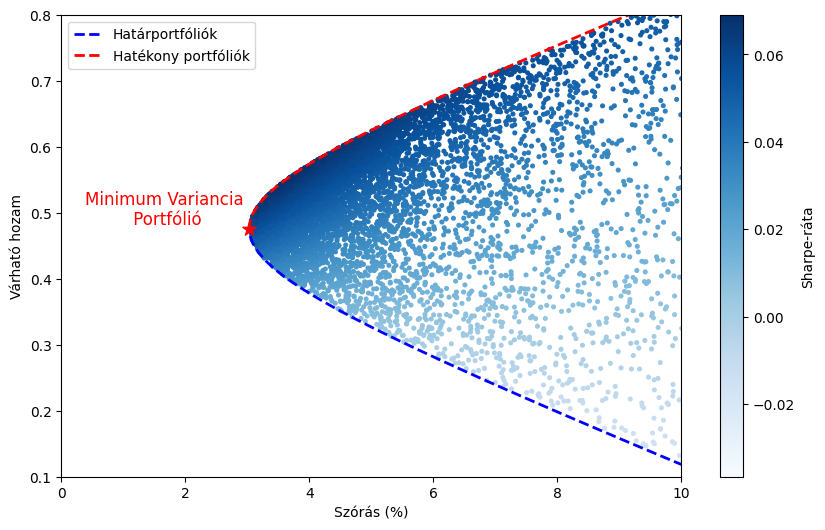

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Function to download stock data
def load_yfinance_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Function to calculate daily returns
def calculate_returns(data):
    return data.pct_change().dropna()

# Function to calculate portfolio statistics
def portfolio_statistics(weights, returns, covariance):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(252)  # Annualized volatility
    return portfolio_return, portfolio_volatility

# Function to calculate the efficient frontier
def efficient_frontier(returns, num_portfolios, risk_free_rate):
    cov_matrix = returns.cov() * 252  # Annualize the covariance matrix
    expected_returns = returns.mean() * 252  # Annualize the returns
    num_assets = len(expected_returns)
    results = np.zeros((4, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.randn(num_assets)
        weights /= np.sum(weights)        
        portfolio_return, portfolio_volatility = portfolio_statistics(weights, returns, cov_matrix)
        results[0,i] = portfolio_volatility
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility  # Sharpe ratio

    return results

# Function to find the minimum variance portfolio
def minimum_variance_portfolio(cov_matrix):
    num_assets = len(cov_matrix)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, cov: np.dot(weights.T, np.dot(cov, weights)),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Function to find the market portfolio (highest Sharpe ratio)
def market_portfolio(returns, covariance, risk_free_rate):
    num_assets = len(returns)
    args = (returns, covariance, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, returns, cov, rf: -(np.dot(weights, returns) - rf) / np.sqrt(np.dot(weights.T, np.dot(cov, weights))),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Plotting function for the efficient frontier
def plot_efficient_frontier(results, exact_frontier_returns, exact_frontier_volatilities, 
                            mvp_return, mvp_volatility, market_return, market_volatility, 
                            risk_free_rate, min_x, max_x, min_y, max_y):
    plt.figure(figsize=(10, 6))

    # Set the same limits as in Manim
    plt.xlim(min_x, max_x )  # Volatility range
    plt.ylim(min_y, max_y )  # Expected return range

    # Scatter plot for simulated portfolios
    results[0,:]+=0.015
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='Blues', marker='o', s=7, alpha=1)
    plt.colorbar(label='Sharpe-ráta')

    # Line plot for the exact efficient frontier
    min_vol =  np.array(exact_frontier_volatilities).min()
    min_vol_pos = np.where(np.array(exact_frontier_volatilities) == min_vol)[0][0]
    print(min_vol_pos)
    plt.plot(exact_frontier_volatilities[:min_vol_pos], exact_frontier_returns[:min_vol_pos], 'b--', label='Határportfóliók', linewidth=2)
    
    plt.plot(exact_frontier_volatilities[min_vol_pos:], exact_frontier_returns[min_vol_pos:], 'r--', label='Hatékony portfóliók', linewidth=2)

   

    

    # # Plot the Capital Market Line (CML)
    # cml_x = np.linspace(min_x, max_x, 100)
    # cml_y = risk_free_rate + (market_return - risk_free_rate) / market_volatility * cml_x
    # plt.plot(cml_x, cml_y, color='red', linestyle='-', label='Tőkepiaci Egyenes (CML)', zorder=1)
    # # plt.text(0.55, 0.3, 'MVP', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='black')

    plt.scatter(mvp_volatility, mvp_return, color='red', marker='*', s=100, zorder=2)
    plt.text(mvp_volatility, mvp_return, 'Minimum Variancia \n Portfólió         ', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='red')

    # Plot the market portfolio with a red color
    # plt.scatter(market_volatility, market_return, color='red', marker='o', s=100, zorder=3)
    # plt.text(market_volatility, market_return, 'Piaci Portfólió', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')
    # sample1_volatility, sample1_return=5,0.5
    # cal_x = np.linspace(min_x, max_x, 100)
    # cal_y = risk_free_rate + (sample1_return - risk_free_rate) / sample1_volatility * cal_x
    # plt.plot(cal_x, cal_y, color='blue', linestyle='-', label='Tőkeallokációs egyenesek (CAL)', zorder=1)
    # # plt.text(0.55, 0.3, 'MVP', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='black')

    # # Plot the market portfolio with a red color
    # plt.scatter(sample1_volatility, sample1_return, color='red', marker='o', s=100, zorder=3)
    # plt.text(sample1_volatility, sample1_return, '$P_1$', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')
    
    # sample2_volatility, sample2_return= 8, 0.4
    # cal_x = np.linspace(min_x, max_x, 100)
    # cal_y = risk_free_rate + (sample2_return - risk_free_rate) / sample2_volatility * cal_x
    # plt.plot(cal_x, cal_y, color='blue', linestyle='-', zorder=1)
    # # plt.text(0.55, 0.3, 'MVP', fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='black')

    # # Plot the market portfolio with a red color
    # plt.scatter(sample2_volatility, sample2_return, color='red', marker='o', s=100, zorder=3)
    # plt.text(sample2_volatility, sample2_return, '$P_2$', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')

    # plt.scatter(0, risk_free_rate, color='blue', marker='x', s=100, zorder=3)
    # plt.text(0, risk_free_rate, '$r_f$', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')
    
    
    # plt.title('Hatékony határvonal és tőkepiaci vonal')
    plt.xlabel('Szórás (%)')
    plt.ylabel('Várható hozam')
    plt.legend()
    # plt.show()

# Loading data
risk_free_rate=0.3
num_portfolios=10000
min_x, max_x = 0, 10
min_y, max_y = 0.1, 0.8
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
data = load_yfinance_data(tickers, '2023-01-01', '2024-01-01')
returns = calculate_returns(data)

# Simulated efficient frontier
results = efficient_frontier(returns, num_portfolios, risk_free_rate)

# Exact efficient frontier calculations (refactored from the previous code)

mu = returns.mean() * 252  # Annualize the daily returns
Sigma = returns.cov() * 252  # Annualize the daily covariances
Sigma_inv = np.linalg.inv(Sigma)
ones = np.ones(len(mu))
U = np.vstack([mu, ones]).T
M = U.T@ (Sigma_inv@ U)
M_inv = np.linalg.inv(M)
desired_returns = np.linspace(min_y, max_y , 100)  # Adjusted to match Manim
exact_weights_list = []
exact_risk_list = []

for desired_return in desired_returns:
    u = np.array([desired_return, 1])
    w_star = Sigma_inv@ U@ M_inv@u
    portfolio_risk = np.sqrt(np.dot(w_star.T, np.dot(Sigma, w_star))) * np.sqrt(252)
    exact_weights_list.append(w_star)
    exact_risk_list.append(portfolio_risk)

# Find the minimum variance portfolio
mvp_weights = minimum_variance_portfolio(Sigma)
mvp_return, mvp_volatility = portfolio_statistics(mvp_weights, returns, Sigma)

# Find the market portfolio
market_weights = market_portfolio(mu, Sigma, risk_free_rate)
market_return, market_volatility = portfolio_statistics(market_weights, returns, Sigma)

# Plot both the simulated and exact efficient frontiers
plot_efficient_frontier(results, desired_returns, exact_risk_list, mvp_return, mvp_volatility, market_return, market_volatility, risk_free_rate, min_x, max_x, min_y, max_y)
plt.savefig("../../../static/MPT/MPT3.svg", format='svg', transparent=True, bbox_inches='tight')

# Show the plot
plt.show()


[*********************100%%**********************]  4 of 4 completed


53


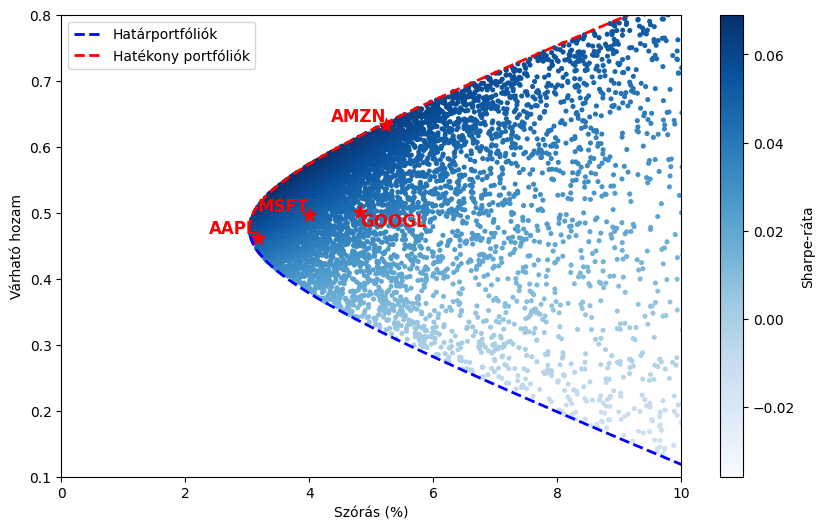

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Function to download stock data
def load_yfinance_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Function to calculate daily returns
def calculate_returns(data):
    return data.pct_change().dropna()

# Function to calculate portfolio statistics
def portfolio_statistics(weights, returns, covariance):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(252)  # Annualized volatility
    return portfolio_return, portfolio_volatility

# Function to calculate the efficient frontier
def efficient_frontier(returns, num_portfolios, risk_free_rate):
    cov_matrix = returns.cov() * 252  # Annualize the covariance matrix
    expected_returns = returns.mean() * 252  # Annualize the returns
    num_assets = len(expected_returns)
    results = np.zeros((4, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.randn(num_assets)
        weights /= np.sum(weights)        
        portfolio_return, portfolio_volatility = portfolio_statistics(weights, returns, cov_matrix)
        results[0,i] = portfolio_volatility
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility  # Sharpe ratio

    return results

# Function to find the minimum variance portfolio
def minimum_variance_portfolio(cov_matrix):
    num_assets = len(cov_matrix)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, cov: np.dot(weights.T, np.dot(cov, weights)),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Function to find the market portfolio (highest Sharpe ratio)
def market_portfolio(returns, covariance, risk_free_rate):
    num_assets = len(returns)
    args = (returns, covariance, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, returns, cov, rf: -(np.dot(weights, returns) - rf) / np.sqrt(np.dot(weights.T, np.dot(cov, weights))),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Plotting function for the efficient frontier
def plot_efficient_frontier(results, exact_frontier_returns, exact_frontier_volatilities, 
                            mvp_return, mvp_volatility, market_return, market_volatility, 
                            risk_free_rate, min_x, max_x, min_y, max_y,returns, tickers):
    plt.figure(figsize=(10, 6))

    # Set the same limits as in Manim
    plt.xlim(min_x, max_x )  # Volatility range
    plt.ylim(min_y, max_y )  # Expected return range

    # Scatter plot for simulated portfolios
    results[0,:]+=0.015
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='Blues', marker='o', s=7, alpha=1)
    plt.colorbar(label='Sharpe-ráta')

    # Line plot for the exact efficient frontier
    min_vol =  np.array(exact_frontier_volatilities).min()
    min_vol_pos = np.where(np.array(exact_frontier_volatilities) == min_vol)[0][0]
    print(min_vol_pos)
    plt.plot(exact_frontier_volatilities[:min_vol_pos], exact_frontier_returns[:min_vol_pos], 'b--', label='Határportfóliók', linewidth=2)
    
    plt.plot(exact_frontier_volatilities[min_vol_pos:], exact_frontier_returns[min_vol_pos:], 'r--', label='Hatékony portfóliók', linewidth=2)
    for tick in tickers:
        if tick == 'GOOGL':
            plt.scatter(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, color='red', marker='*', s=100, zorder=2, )
            plt.text(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, tick, fontsize=12, fontweight="bold", verticalalignment='top', horizontalalignment='left', color='red')
        else:
            plt.scatter(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, color='red', marker='*', s=100, zorder=2, )
            plt.text(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, tick, fontsize=12, fontweight="bold", verticalalignment='bottom', horizontalalignment='right', color='red')

    # plt.title('Hatékony határvonal és tőkepiaci vonal')
    plt.xlabel('Szórás (%)')
    plt.ylabel('Várható hozam')
    plt.legend()
    # plt.show()

# Loading data
risk_free_rate=0.3
num_portfolios=10000
min_x, max_x = 0, 10
min_y, max_y = 0.1, 0.8
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
data = load_yfinance_data(tickers, '2023-01-01', '2024-01-01')
returns = calculate_returns(data)

# Simulated efficient frontier
results = efficient_frontier(returns, num_portfolios, risk_free_rate)

# Exact efficient frontier calculations (refactored from the previous code)

mu = returns.mean() * 252  # Annualize the daily returns
Sigma = returns.cov() * 252  # Annualize the daily covariances
Sigma_inv = np.linalg.inv(Sigma)
ones = np.ones(len(mu))
U = np.vstack([mu, ones]).T
M = U.T@ (Sigma_inv@ U)
M_inv = np.linalg.inv(M)
desired_returns = np.linspace(min_y, max_y , 100)  # Adjusted to match Manim
exact_weights_list = []
exact_risk_list = []

for desired_return in desired_returns:
    u = np.array([desired_return, 1])
    w_star = Sigma_inv@ U@ M_inv@u
    portfolio_risk = np.sqrt(np.dot(w_star.T, np.dot(Sigma, w_star))) * np.sqrt(252)
    exact_weights_list.append(w_star)
    exact_risk_list.append(portfolio_risk)

# Find the minimum variance portfolio
mvp_weights = minimum_variance_portfolio(Sigma)
mvp_return, mvp_volatility = portfolio_statistics(mvp_weights, returns, Sigma)

# Find the market portfolio
market_weights = market_portfolio(mu, Sigma, risk_free_rate)
market_return, market_volatility = portfolio_statistics(market_weights, returns, Sigma)

# Plot both the simulated and exact efficient frontiers
plot_efficient_frontier(results, desired_returns, exact_risk_list, mvp_return, mvp_volatility, market_return, market_volatility, risk_free_rate, min_x, max_x, min_y, max_y, returns, tickers)
plt.savefig("../../../static/MPT/MPT4.svg", format='svg', transparent=True, bbox_inches='tight')

# Show the plot
plt.show()
